In [2]:
import pandas as pd

gene_expression = pd.read_csv("./data/RNA_expression_curated.csv", sep=',', header=0, index_col=0)
drug_response = pd.read_csv("./data/drug_response_curated.csv", sep=',', header=0, index_col=0)

# Exercises

## Selection of the hyperparameter

Implement cross-validation (using `sklearn.grid_search.GridSearchCV`) to select the `alpha` hyperparameter of `sklearn.linear_model.Lasso`. 

In [3]:
# current runtime is 4-5 minutes
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
import warnings

with warnings.catch_warnings():  # disable overly verbose ConvergenceWarnings
    warnings.simplefilter("ignore", category=ConvergenceWarning)

    Lasso_est = Lasso(random_state=0, max_iter=10000)

    alpha_vals = np.logspace(-4, 3, 80)
    parameter = {'alpha': alpha_vals}

    n_folds = 10
    gridsearch = GridSearchCV(Lasso_est, parameter, cv=n_folds, refit=False)

    gridsearch.fit(gene_expression, drug_response)

scores = gridsearch.cv_results_["mean_test_score"]
scores_std = gridsearch.cv_results_["std_test_score"]

max_score = np.max(scores)
alpha_index = np.where(scores==max_score)[0][0]
optimal_alpha = alpha_vals[alpha_index]

print("The highest score is:", max_score)
print("The optimal alpha value is:", optimal_alpha)


KeyboardInterrupt





## Feature selection

Look at the features selected using the hyperparameter which corresponds to the minimum cross-validation error.

<p><font color='#770a0a'>Is the partition in training and validation sets playing a role in the selection of the hyperparameter? How will this affect the selection of the relevant features?</font></p>

<p><font color='#770a0a'>Should the value of the intercept also be shrunk to zero with Lasso and Ridge regression? Motivate your answer.</font></p>

In [5]:
# Fit a lasso regression using the optimal alpha
optimal_lasso = Lasso(alpha=optimal_alpha, random_state=0, max_iter=1000)
optimal_lasso.fit(gene_expression, drug_response)

# Obtain the coefficients for the fit and select those who have not been shrunk to 0
coefficients = optimal_lasso.coef_
selected_features = np.where(coefficients != 0)[0]

# Print the selected features. 
print('The selected features are:', gene_expression.columns[selected_features].values)

The selected features are: ['GAL' 'ABCB1' 'TSPAN8' 'SELENBP1' 'FABP1' 'TACSTD2' 'AKR1C3']


Answer question 1:

Normally the train and validation split plays a crucial role in the selection of the hyperparameter, however to increase the robustness of our model we choose to do cross-validation. This way we see different splits and by averaging their results get a better estimate of the effictiveness of a certain alpha. The alpha parameter in Lasso regression shrinks certain features to zero if they are not significant to the prediction, if we find a different optimal alpha value due to a different train test split this will influence which features are set to zero and thus discarded by the model. 

Answer question 2:

No, the intercept should generally not be set to zero since we are using an affine function. The intercept represents the expected value of y if we discard all features or rather set them to 0. If we set the intercept to zero we will introduce bias in the model by forcing this expected value of y to be zero which generally is not a good representation of the data. 


## Bias-variance 

Show the effect of the regularization on the parameter estimates in terms of bias and variance. For this you can repeat the optimization 100 times using bootstrap and visualise the profile of the Lasso regression coefficient over a grid of the hyperparameter, optionally including the variability as error bars.

<p><font color='#770a0a'>Based on the visual analysis of the plot, what are your observation on bias and variance in relation to model complexity? Motivate your answer.</font></p>

In [6]:
# Current runtime is 3-5 minutes
from sklearn.utils import resample

# Initialize a matrix for saving all coefficients for each bootstrap-alpha_value combination
coefficients_matrix = np.zeros((100, len(alpha_vals), gene_expression.shape[1]))

with warnings.catch_warnings():  # disable overly verbose ConvergenceWarnings
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    
    # Bootstrapping the outer loop by resampling the same dataset
    for i in range(100):
        resample_genes, resample_response = resample(gene_expression, drug_response, random_state=i)

        # For each value in alpha for obtain the coefficients for each bootstrap
        for j, alpha in enumerate(alpha_vals):
            
            # Fit the lasso for a certain alpha value
            lasso = Lasso(alpha=alpha)
            lasso.fit(resample_genes, resample_response)
            
            # Obtain and save the coefficients
            bootstrap_alpha_coef = lasso.coef_
            coefficients_matrix[i, j, :] = bootstrap_alpha_coef

C:\Users\20182717\AppData\Local\Temp\ipykernel_10988\853742513.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma', gene_expression.shape[1])
C:\Users\20182717\AppData\Local\Temp\ipykernel_10988\853742513.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(cmap=cmap,norm=norm),label='feature number')


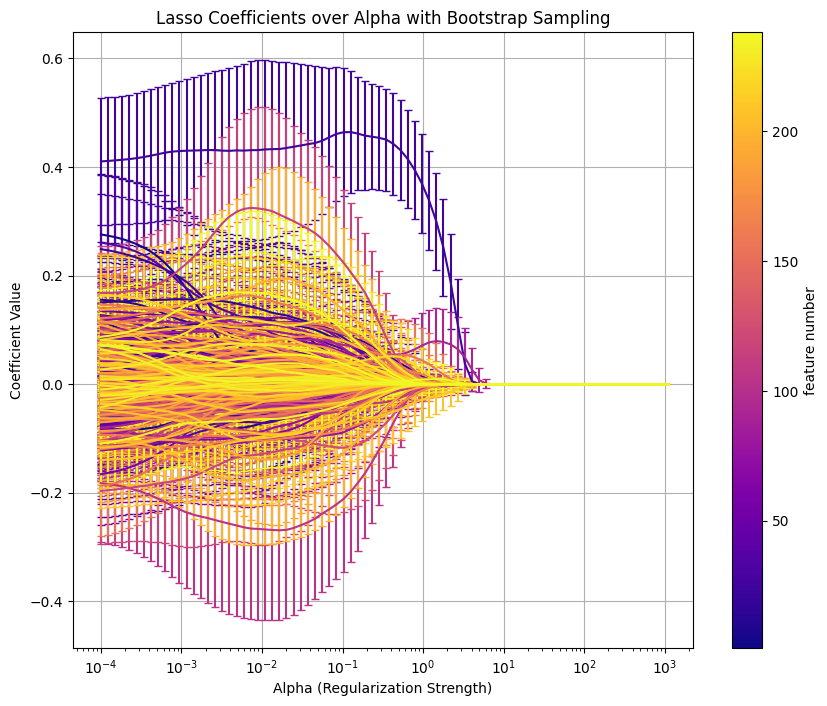

In [7]:
# Visualizing the coefficient matrix in a different cell to not have to rerun bootstrap every time. 

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors

# Obtaining the mean and std of each of the coefficients reducing the bootstrap dimension 
coeff_mean = np.mean(coefficients_matrix, axis=0)
coeff_std = np.std(coefficients_matrix, axis=0)

cmap = cm.get_cmap('plasma', gene_expression.shape[1])
norm = colors.Normalize(vmin=1,vmax=gene_expression.shape[1])

plt.figure(figsize=(10, 8))
for feature_idx in range(gene_expression.shape[1]):
    plt.errorbar(alpha_vals, coeff_mean[:, feature_idx], yerr=coeff_std[:, feature_idx],
                 label=f'Feature {feature_idx + 1}', capsize=3, color=cmap(feature_idx))
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Coefficient Value')
plt.colorbar(cm.ScalarMappable(cmap=cmap,norm=norm),label='feature number') 
plt.title('Lasso Coefficients over Alpha with Bootstrap Sampling')
plt.grid(True)
plt.show()

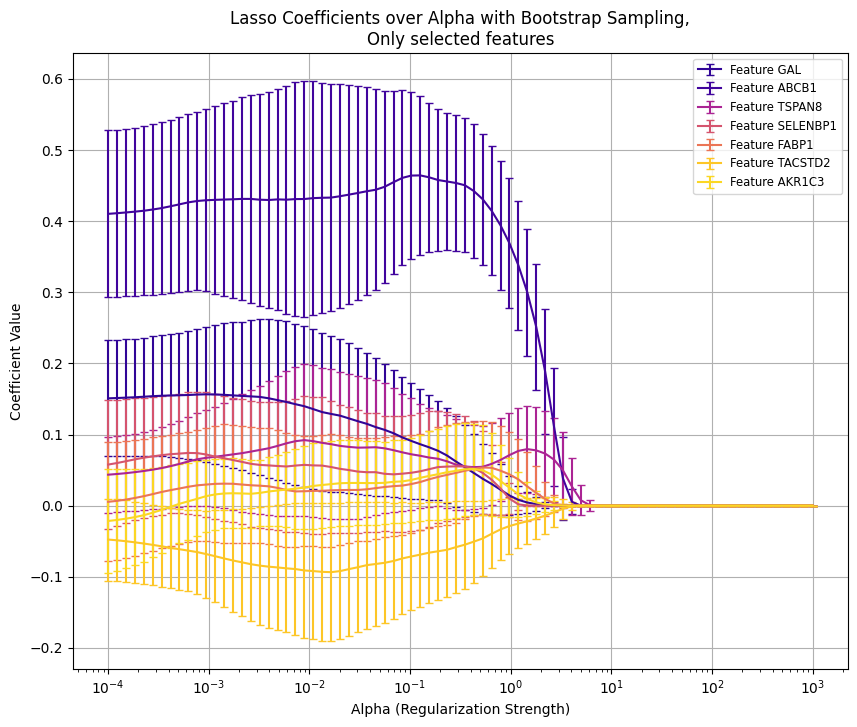

In [8]:
plt.figure(figsize=(10, 8))
for feature_idx in range(gene_expression.shape[1]):
    # print(gene_expression[selected_features])
    if feature_idx in selected_features:
        plt.errorbar(alpha_vals, coeff_mean[:, feature_idx], yerr=coeff_std[:, feature_idx],
                 label=f'Feature {gene_expression.columns[feature_idx]}', capsize=3, color=cmap(feature_idx))
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Coefficient Value')
# plt.colorbar(cm.ScalarMappable(cmap=cmap,norm=norm),label='feature') 
plt.title('Lasso Coefficients over Alpha with Bootstrap Sampling,\nOnly selected features')
plt.legend(loc='best', fontsize='small')
plt.grid(True)

Answer:

As the regularization coefficient increases we see more and more of the coefficients reduced to zero. This means that as alpha increases our model complexity decreases as well. A more complex model usually has less bias but higher variance, thus meaning with a higher alpha we obtain less bias but higher variance and with a lower alpha we obtain more bias but less variance.


## Logistic regression

<p><font color='#770a0a'>Write the expression of the objective function for the penalized logistic regression with $L_1$ and $L_2$ regularisation (as in Elastic net).</font></p>

The expression for the objective of elastic net in logistic regression is:

$L(\beta) = -(\frac{1}{n} * \sum _{i=1}^n[y_i * log(p_i) + (1- y_i)*log(1-p_i)]) + \alpha * (\frac{1-\rho}{2}\sum^p_{j=1} \beta _j^2 + \rho \sum ^p _{j=1}|\beta _j|) $

Here the expression consists of two main parts, the objective function and the elastic net regularization:

The objective function consists of a sum over all samples where we take the average of n samples over two parts:

The left part 'activates' when the true label is 1 and equates the log of $p_i$ which is the prediction of the logistic regression ($p_i=\frac{1}{1+exp(X_i\beta)}$)

The right part represents the probability of $log(1-p_i)$ only when the true lable is 0

Then we have the regularization part of the elastic net formula:

We have two hyperparamters which are alpha corresponding the strength of the regularization and a new hyperparameter rho representing the ratio between L1 and L2 regularization. 

Then again we have a left part representing L2 regularization in beta squared which helps against large coefficients reducing overfitting. 

And we have right part representing L1 regularization shrinking small coefficients 